In [1]:
import plotly.express as px
from tinyshift.series import trend_significance
from utilsforecast.preprocessing import fill_gaps
from utils import remove_leading_zeros, is_obsolete, forecastability, generate_lag
from tinyshift.series import fourier_seasonality
from tinyshift.plot import stationarity_check, seasonal_decompose, pami, residual_check, corr_heatmap
import pandas as pd
from tinyshift.modelling import filter_features_by_vif
import numpy as np

In [2]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url, parse_dates=['Month'])
df["unique_id"] = "1"
df.rename(columns={"Month": "ds", "Passengers": "y"}, inplace=True)

In [3]:
df.isnull().sum()

ds           0
y            0
unique_id    0
dtype: int64

In [4]:
df

,ds,y,unique_id
0,1949-01-01,112,1
1,1949-02-01,118,1
2,1949-03-01,132,1
3,1949-04-01,129,1
4,1949-05-01,121,1
...,...,...,...
139,1960-08-01,606,1
140,1960-09-01,508,1
141,1960-10-01,461,1
142,1960-11-01,390,1


In [5]:
df = fill_gaps(df, freq="ME", end="per_serie", id_col="unique_id", time_col="ds")

In [6]:
df = df.groupby("unique_id")[df.columns].apply(remove_leading_zeros).reset_index(drop=True)

In [7]:
days_obsoletes=180
obsolete_series = df.groupby("unique_id")[df.columns].apply(is_obsolete, days_obsoletes)

In [8]:
obsolote_ids = obsolete_series[obsolete_series].index.tolist()

In [9]:
obsolote_ids

[]

In [10]:
df.groupby("unique_id")["y"].apply(trend_significance)

unique_id
1    (0.853638165603188, 4.020274506593391e-61)
Name: y, dtype: object

In [11]:
px.line(df, x="ds", y="y", facet_col="unique_id")

In [12]:
px.line(df, x="ds", y="y", facet_col="unique_id")

In [13]:
df.groupby("unique_id")["y"].apply(forecastability)

unique_id                   
1          foreCA                                               0.571263
           theoretical_limit                                    0.086973
           stability_index                                      0.183962
           adi_cv                             (1.0, 0.18190737443351804)
           hurst_exponent       (0.5203628364992473, 0.8044229708616066)
Name: y, dtype: object

# Stationarity Analysis

In [14]:
df["lag_1"] = generate_lag(df["y"], lag=1)
df["lag_12"] = generate_lag(df["lag_1"], lag=12)

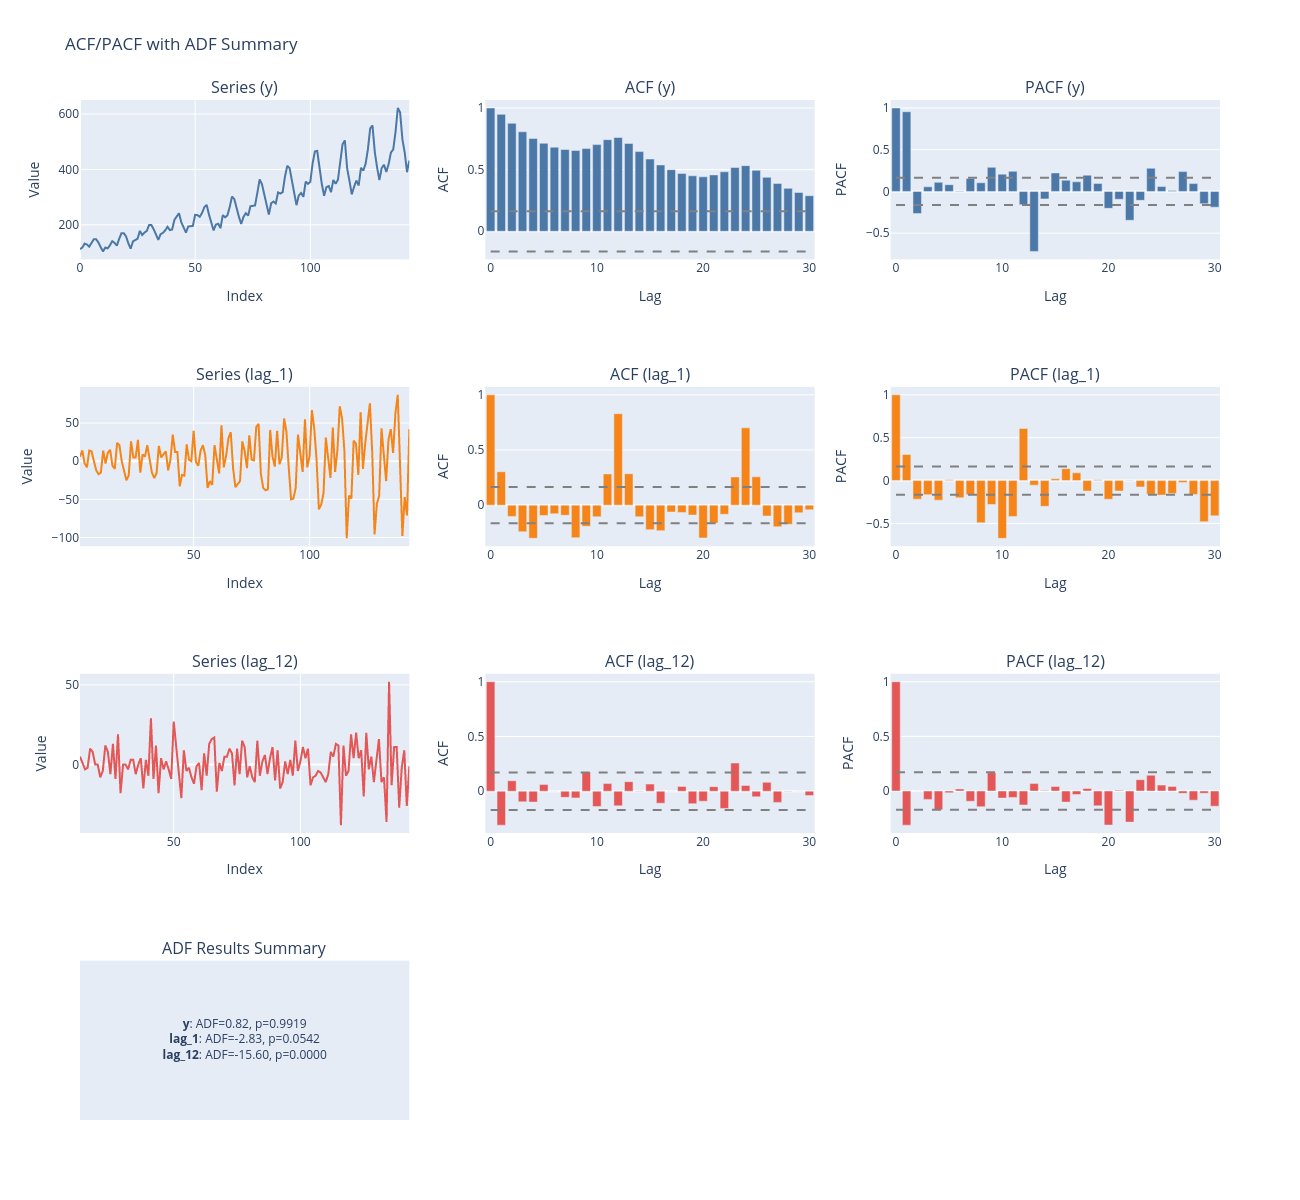

In [15]:
stationarity_check(df[["y", "lag_1", "lag_12"]], fig_type="png")

In [16]:
df.drop(columns=["lag_1", "lag_12"], inplace=True)

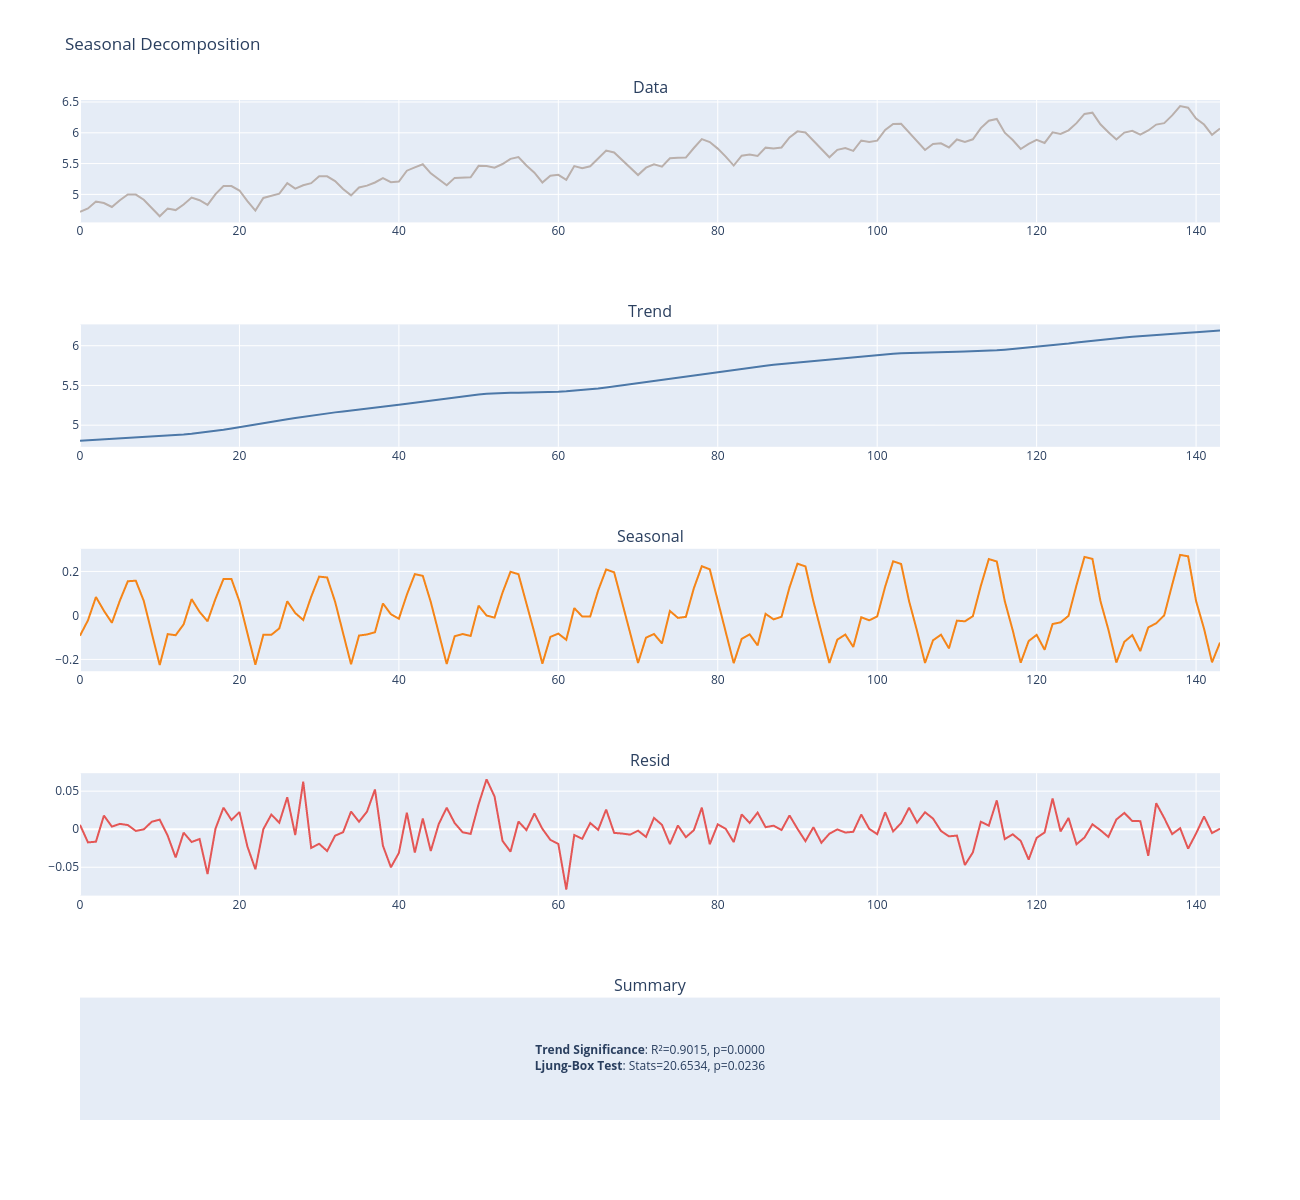

In [17]:
seasonal_decompose(np.log(df["y"]), periods=12, fig_type="png")

# PAMI

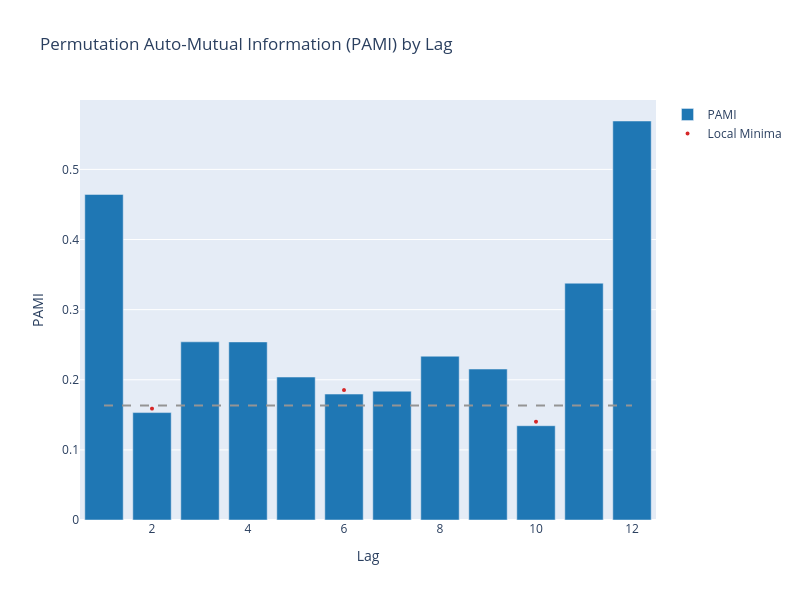

In [18]:
for id in df["unique_id"].unique():
    pami(df.loc[df["unique_id"] == id, "y"], nlags=12, m=3, delay=1, normalize=True, fig_type="png")

# Modelagem Estatística

In [19]:
from statsforecast.models import AutoARIMA, Naive, AutoETS, AutoTheta, AutoCES, AutoMFLES
from utilsforecast.losses import rmse, mae, bias, cfe, smape
from statsforecast import StatsForecast
from utilsforecast.evaluation import evaluate

/home/heylucasleao/forecasting/.venv/lib/python3.10/site-packages/fs/__init__.py:4: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.

/home/heylucasleao/forecasting/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [20]:
seasonal_length = 12
sf = StatsForecast(
    models=[
        AutoARIMA(season_length=seasonal_length),
        AutoETS(season_length=seasonal_length),
        AutoTheta(season_length=seasonal_length),
        AutoCES(season_length=seasonal_length),
        AutoMFLES(season_length=seasonal_length, test_size=3, n_windows=5, metric = "mae"),
    ],
    freq='MS',
    fallback_model=Naive(),
    n_jobs=-1
)

In [21]:
horizon = 12
df = fourier_seasonality(df, "ds", seasonality=["monthly"])
#df["RANDOM_FEATURE_1"] = np.random.rand(len(df))
#df["RANDOM_FEATURE_2"] = np.random.normal(size=len(df))
train = df[:-horizon]
test = df[-horizon:]

In [22]:
fc = sf.forecast(df=train[["unique_id", "ds", "y"]], h=horizon) #fit_predict

In [23]:
def wape(df, models, id_col='unique_id', target_col='y'):
    """
    Calcula o WAPE (Weighted Absolute Percentage Error).
    'df' é o DataFrame de avaliação com 'unique_id', 'ds', 'y' (target) e colunas de modelo.
    """
    actual = df[target_col].to_numpy()

    results = {}
    for model_name in models:
        forecast = df[model_name].to_numpy()

        numerator = np.sum(np.abs(forecast - actual))
        denominator = np.sum(np.abs(actual))

        if denominator == 0:
            wape_score = 0.0 
        else:
            wape_score = numerator / denominator

        results[model_name] = wape_score

    return pd.DataFrame({
        'unique_id': df[id_col].unique(),
        'metric': 'wape',
        **results
    })

In [24]:
metrics = [
    mae,
    rmse,
    bias,
    cfe,
    wape,
    smape
]

models = ["AutoARIMA", "AutoETS", "AutoTheta", "CES", "SCUM", "AutoMFLES"]
scum = ["AutoARIMA", "AutoETS", "AutoTheta", "CES"]
fc["SCUM"] = fc[scum].median(axis=1)
fc.loc[fc["SCUM"] < 1e-1, "SCUM"] = 0

In [25]:
test = pd.merge(test, fc, on=["unique_id", "ds"], how="inner")
columns = ["unique_id", 
               "ds", 
               "y", 
               "AutoARIMA", 
               "AutoETS", 
               "AutoTheta", 
               "CES", 
               "SCUM", "AutoMFLES"]

In [26]:
evaluate(test[columns], 
         metrics=metrics, 
         models=models, 
         id_col="unique_id", 
         time_col="ds", 
         target_col="y")

,unique_id,metric,AutoARIMA,AutoETS,AutoTheta,CES,SCUM,AutoMFLES
0,1,mae,18.515821,35.612475,19.357396,10.145073,12.008021,15.627861
1,1,rmse,23.919481,40.083621,24.985159,14.657908,16.899254,21.679438
2,1,bias,16.968961,-27.608716,-9.096141,5.823789,-2.396108,14.260185
3,1,cfe,203.627533,-331.304596,-109.153687,69.885468,-28.753296,171.122223
4,1,wape,0.038885,0.074790,0.040653,0.021306,0.025218,0.032820
5,1,smape,0.020156,0.037253,0.019655,0.010630,0.012573,0.016938


# Machine Learning (Linear Regression & Random Forest)

In [27]:
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean, SeasonalRollingMean
from mlforecast.target_transforms import Differences
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from mlforecast.target_transforms import Differences
from lightgbm import LGBMRegressor
from numba import njit

In [28]:
@njit
def hampel_filter(
    x: np.ndarray,
    window_size: int,
    factor: float = 3.0,
    scale: float = 1.4826,
) -> np.ndarray:
    """
    Identify outliers using a Numba-compiled implementation of the Hampel filter.

    The Hampel filter is a robust outlier detection method that uses the median and
    median absolute deviation (MAD) of a rolling window to identify points that
    deviate significantly from the local trend. This version is compiled with Numba
    for high-performance execution and compatibility with the Nixtla ecosystem.

    Parameters
    ----------
    x : ndarray of shape (n_samples,)
        Input 1D data to be filtered.
    window_size : int
        Size of the rolling window (must be odd and >= 3).
    factor : float, default=3.0
        Recommended values for common distributions (95% confidence):
        - Normal distribution: 3.0 (default)
        - Laplace distribution: 2.3
        - Cauchy distribution: 3.4
        - Exponential distribution: 3.6
        - Uniform distribution: 3.9
        Number of scaled MADs from the median to consider as outlier.
    scale : float, default=1.4826
        Scaling factor for MAD to make it consistent with standard deviation.
        Recommended values for different distributions:
        - Normal distribution: 1.4826 (default)
        - Uniform distribution: 1.16
        - Laplace distribution: 2.04
        - Exponential distribution: 2.08
        - Cauchy distribution: 1.0 (MAD is already consistent)

    Returns
    -------
    is_outlier : ndarray of shape (n_samples,)
        Boolean array indicating outliers (True) and inliers (False).

    Notes
    -----
    This function is JIT-compiled with Numba for optimal performance in the
    Nixtla ecosystem.
    """

    if window_size < 3 or window_size % 2 == 0:
        pass

    n = len(x)
    is_outlier = np.zeros(n, dtype=np.bool_)

    for i in range(n):
        start = max(0, i - window_size + 1)
        end = i + 1

        window = x[start:end]

        if len(window) < window_size:
            continue

        window_no_nan = window[~np.isnan(window)]

        if len(window_no_nan) < window_size:
            continue

        median = np.median(window_no_nan)
        mad = np.median(np.abs(window_no_nan - median))
        threshold = factor * mad * scale

        current_value = x[i]

        if np.isnan(current_value):
            continue

        if np.abs(current_value - median) > threshold:
            is_outlier[i] = True

    return is_outlier


In [29]:
def compute_lgbm_params(N: int):
    max_depth = int(np.ceil(np.log2(N) - 1))
    subsample_freq = 1
    colsample_bytree = 0.7
    n_estimators = 1000
    reg_lambda = 0.2
    reg_alpha = 0.2
    metric = "mae"
    learning_rate = 0.05
    min_child_samples = max(20, int(np.cbrt(N)))
    n_jobs = -1
    random_state = 42

    return {
        "max_depth": int(max_depth),
        "subsample_freq": subsample_freq,
        "colsample_bytree": colsample_bytree,
        "n_estimators": n_estimators,
        "metric": metric,
        "learning_rate": learning_rate,
        "num_leaves": 40,
        "min_child_samples": min_child_samples,
        "reg_alpha": reg_alpha,
        "reg_lambda": reg_lambda,
        "objective": "regression_l2",
        "n_jobs": n_jobs,
        "random_state": random_state
    }

In [30]:
config = compute_lgbm_params(len(train))
models = [LinearRegression(), RandomForestRegressor(random_state=42, n_jobs=-1, max_depth=int(np.ceil(np.log2(len(train)) - 1))), LGBMRegressor(**config, verbosity=-1)]

mf = MLForecast(
    models=models,
    freq='MS',
    lags=[2], #removi lag 1 e lag 12
    lag_transforms={
        1: [
        RollingMean(window_size=12), # Nível de longo prazo (12 meses)]},
        (hampel_filter, 3), # Detecta saltos em janela de 3 meses
        SeasonalRollingMean(window_size=2, season_length=12)
        ],
        6: [ExpandingMean()], # Média acumulada (longo prazo)
    },
    target_transforms=[Differences([1, 12])],
    date_features=["quarter"],
)

mf.fit(train, static_features=[])

MLForecast(models=[LinearRegression, RandomForestRegressor, LGBMRegressor], freq=MS, lag_features=['lag2', 'rolling_mean_lag1_window_size12', 'hampel_filter_lag1_window_size3', 'seasonal_rolling_mean_lag1_season_length12_window_size2', 'expanding_mean_lag6'], date_features=['quarter'], num_threads=1)

In [31]:
res = mf.predict(h=12, X_df=test[["unique_id", "ds", "monthly_sin", "monthly_cos"]])
res["y"] = test["y"]
evaluate(res, 
         metrics=metrics, 
         models=["LinearRegression", "RandomForestRegressor", "LGBMRegressor"], 
         id_col="unique_id", 
         time_col="ds", 
         target_col="y")

,unique_id,metric,LinearRegression,RandomForestRegressor,LGBMRegressor
0,1,mae,12.873039,11.690572,13.377513
1,1,rmse,17.321738,16.109983,17.973882
2,1,bias,9.562533,2.894140,-0.960322
3,1,cfe,114.750397,34.729675,-11.523865
4,1,wape,0.027035,0.024551,0.028094
5,1,smape,0.013963,0.012692,0.014381


In [32]:
def standardize_coefficients(model: LinearRegression, df_train: pd.DataFrame, target="y"):
    """
    Standardize the coefficients of the model based on the standard deviation of the features and target.
    """
    std_coef = np.zeros(len(model.coef_))
    for i in range(len(model.feature_names_in_)):
        std_coef[i] = model.coef_[i] * df_train[model.feature_names_in_[i]].std() / df_train[target].std()
    return std_coef

In [33]:
feature_importance = pd.DataFrame({
    'feature': mf.models_["LinearRegression"].feature_names_in_,
    'std_coef': standardize_coefficients(mf.models_["LinearRegression"], mf.preprocess(train, static_features=[]))
}).sort_values(by='std_coef', ascending=False).reset_index(drop=True)

In [34]:
feature_importance

,feature,std_coef
0,monthly_sin,0.294905
1,quarter,0.173101
2,hampel_filter_lag1_window_size3,0.167230
3,lag2,0.123664
4,expanding_mean_lag6,-0.013939
5,seasonal_rolling_mean_lag1_season_length12_win...,-0.121614
6,monthly_cos,-0.222613
7,rolling_mean_lag1_window_size12,-0.224129


In [35]:
feature_importance = pd.DataFrame({
    'feature': mf.models_["RandomForestRegressor"].feature_names_in_,
    'importance': mf.models_["RandomForestRegressor"].feature_importances_
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

In [36]:
feature_importance

,feature,importance
0,expanding_mean_lag6,0.225149
1,rolling_mean_lag1_window_size12,0.213664
2,seasonal_rolling_mean_lag1_season_length12_win...,0.192592
3,lag2,0.143550
4,monthly_cos,0.100055
5,monthly_sin,0.097591
6,quarter,0.016133
7,hampel_filter_lag1_window_size3,0.011266


In [37]:
feature_importance = pd.DataFrame({
    'feature': mf.models_["LGBMRegressor"].feature_names_in_,
    'importance': mf.models_["LGBMRegressor"].feature_importances_
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

In [38]:
feature_importance

,feature,importance
0,seasonal_rolling_mean_lag1_season_length12_win...,720
1,lag2,643
2,rolling_mean_lag1_window_size12,570
3,expanding_mean_lag6,564
4,monthly_cos,361
5,monthly_sin,249
6,quarter,35
7,hampel_filter_lag1_window_size3,0


In [39]:
test["residual_LR"] = res["y"] - res["LinearRegression"]
test["residual_RF"] = res["y"] - res["RandomForestRegressor"]
test["residual_LGBM"] = res["y"] - res["LGBMRegressor"]

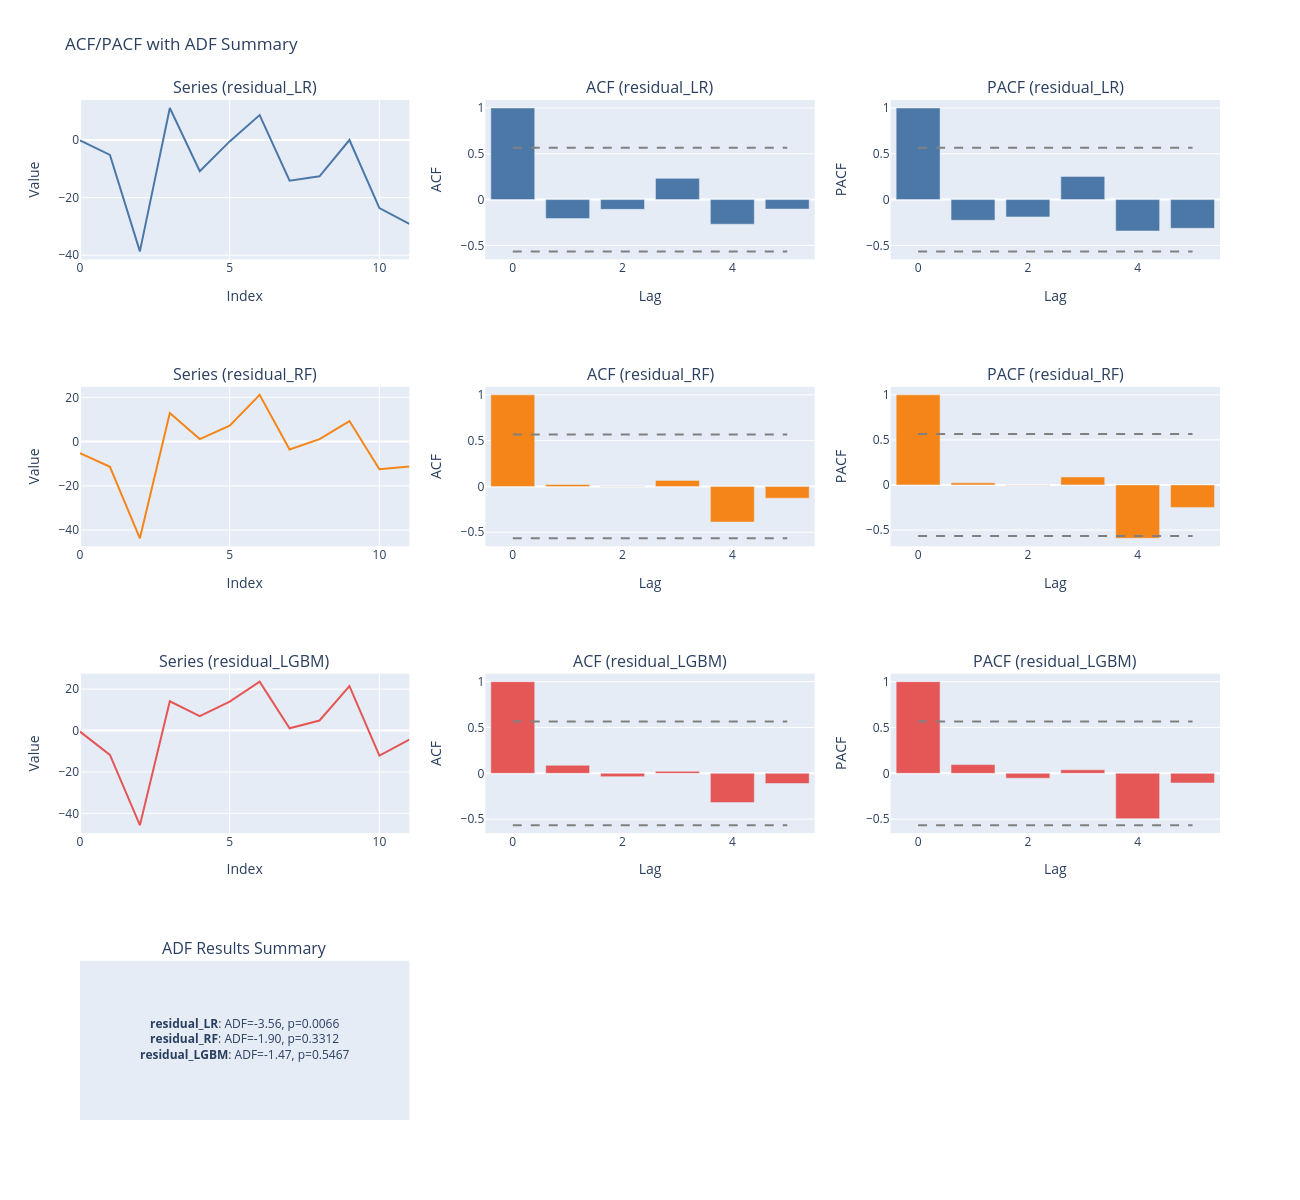

In [40]:
stationarity_check(test[["residual_LR", "residual_RF", "residual_LGBM"]], nlags=30, fig_type="png")

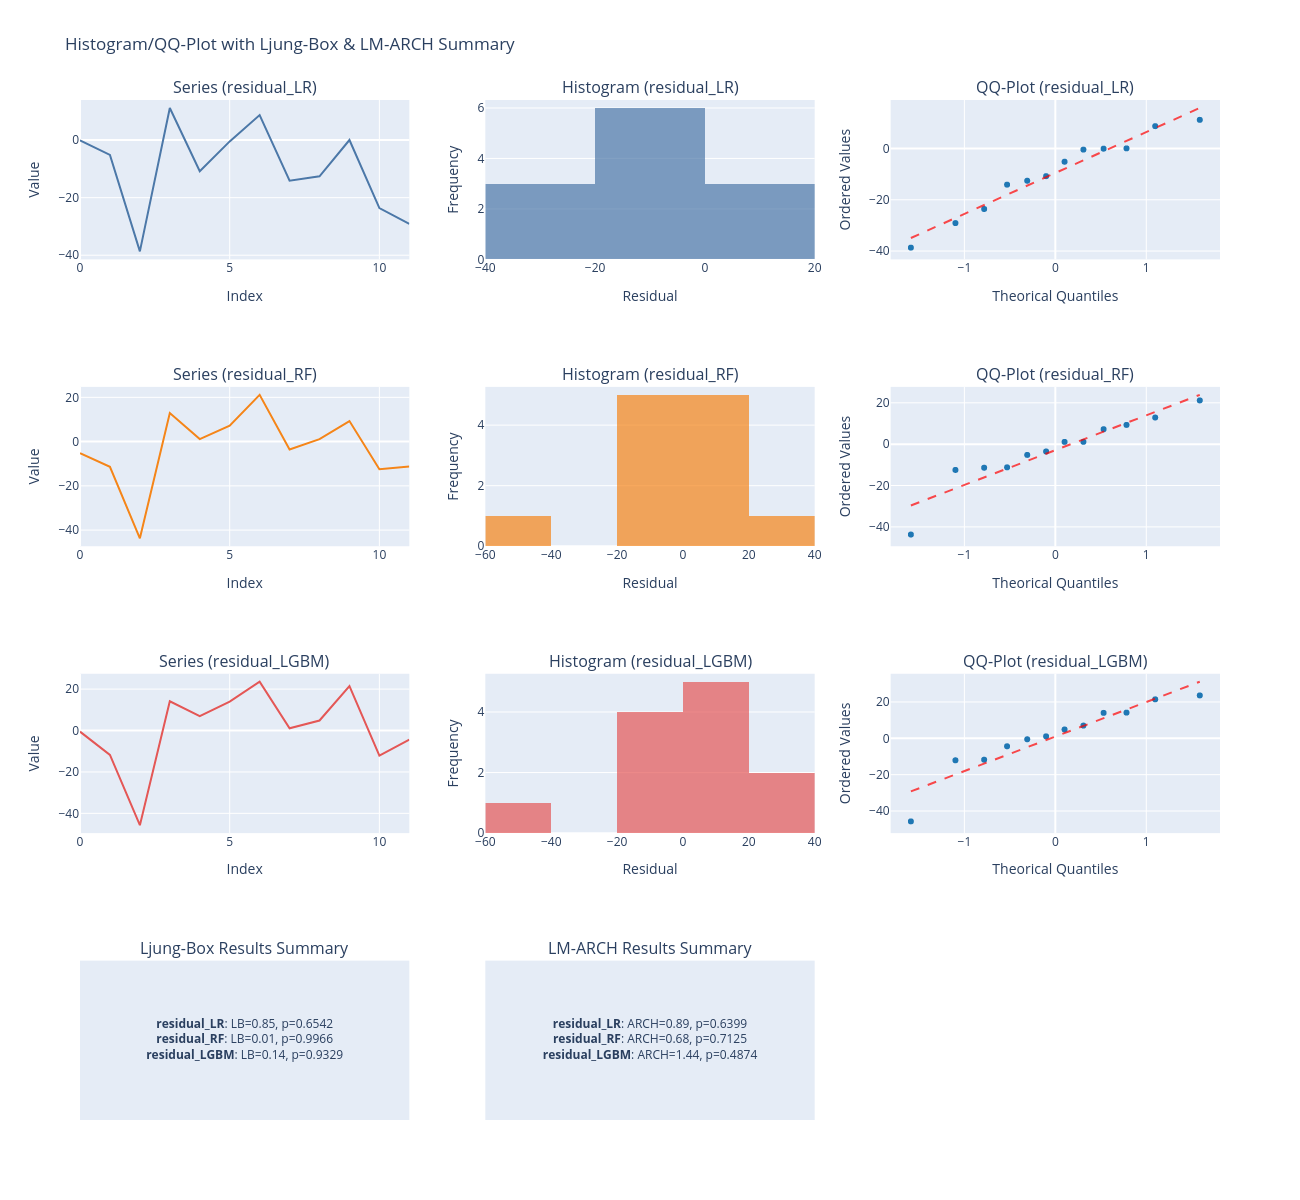

In [41]:
residual_check(test[["residual_LR", "residual_RF", "residual_LGBM"]], nlags=12, fig_type="png")

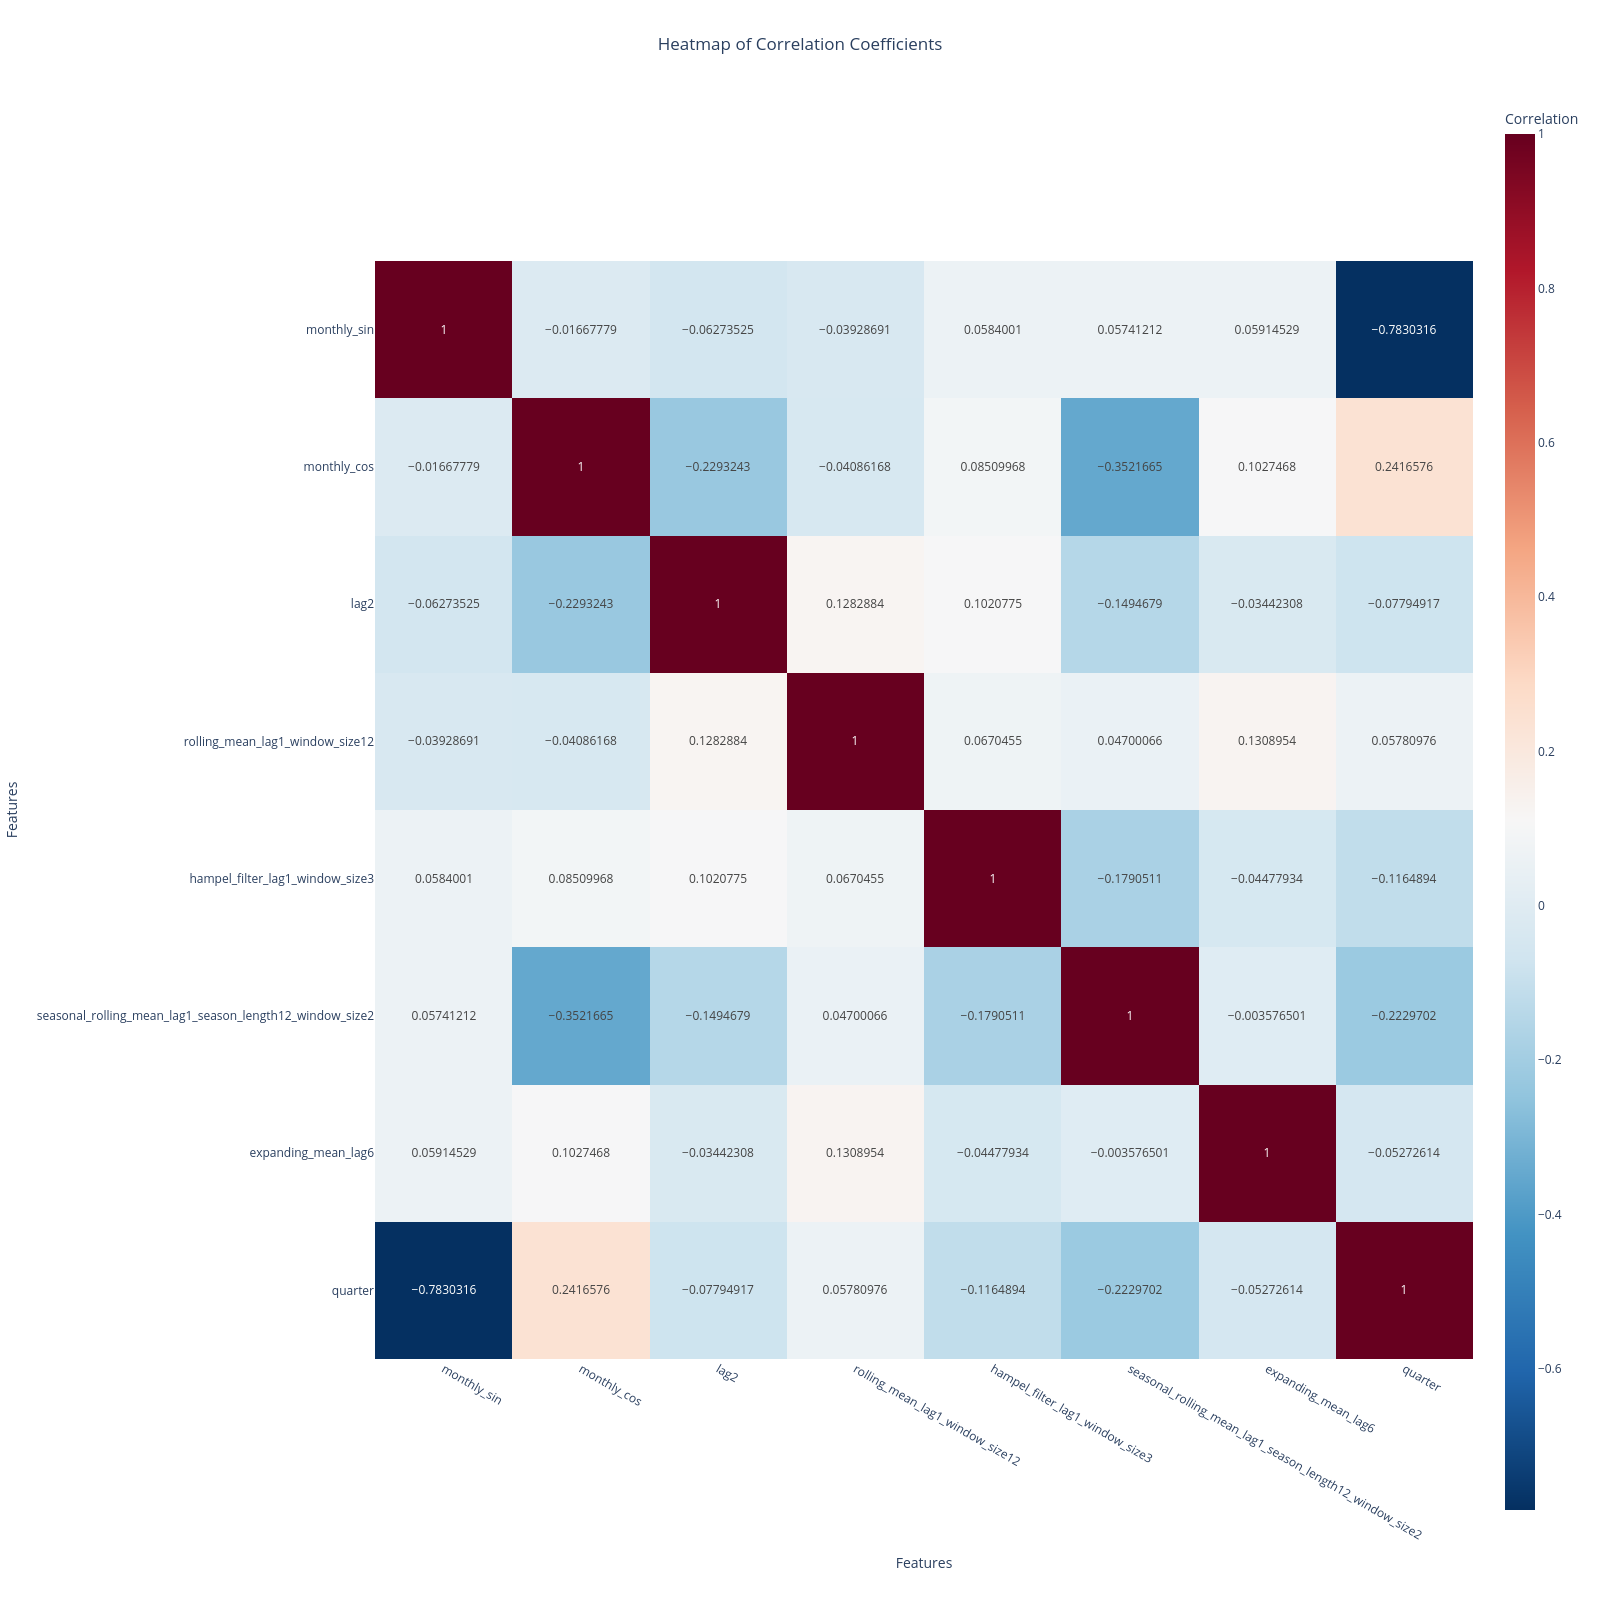

In [42]:
corr_heatmap(mf.preprocess(train, static_features=[]).drop(columns=["unique_id", "ds", "y"]), fig_type="png")

In [43]:
filter_features_by_vif(
    mf.preprocess(train, static_features=[]).drop(columns=["unique_id", "ds", "y"]),
    threshold=5.0,
    verbose=True,
)

array([ True,  True,  True,  True,  True,  True,  True,  True])

# Decomposition + ML

1. Pegar o log de "y"
2. Decompor a série com MSTL
3. Modelar o residual com MLForecast

## 🅰️ Abordagem (a): Tendência Aditiva, Sazonalidade Multiplicativa

In [44]:
import pandas as pd
from sklearn.linear_model import LinearRegression

class LinearRegressionDetrendModels():
    def __init__(self):
        self.models = {} 
        self.last_time_index = {}
        self.freq = None
        self.last_index = {}
    
    def fit(self, df_train, freq, id_col="unique_id", time_col="ds", target_col="y"):
        forecasts = []

        for uid, group in df_train.groupby(id_col):
            self.last_time_index[uid] = group[time_col].max() 
            time_index = np.arange(len(group)).reshape(-1, 1)
            self.last_index[uid] = time_index[-1][0]
            trend_model = LinearRegression()
            trend_model.fit(time_index, group[target_col])
            self.models[uid] = trend_model
            self.freq = freq
            trend_forecast = trend_model.predict(time_index)
            uid_forecast = pd.DataFrame({
                id_col: uid,
                time_col: group[time_col],
                "trend": trend_forecast,
            })
            forecasts.append(uid_forecast)

        return pd.concat(forecasts).reset_index(drop=True)

    def predict(self, h, id_col="unique_id", time_col="ds"):
        
        forecasts = []
        
        for uid in self.models:

            future_dates = pd.date_range(
                start=self.last_time_index[uid],
                periods=h,
                freq=self.freq
            )
            time_index = np.arange(self.last_index[uid] + 1, self.last_index[uid] + h + 1).reshape(-1, 1)
            trend_forecast = self.models[uid].predict(time_index)

            uid_forecast = pd.DataFrame({
                id_col: uid,
                time_col: future_dates,
                "trend": trend_forecast,
            })
            forecasts.append(uid_forecast)
                
        return pd.concat(forecasts).reset_index(drop=True)

In [45]:
train

,unique_id,ds,y,monthly_sin,monthly_cos
0,1,1949-01-01,112,5.000000e-01,8.660254e-01
1,1,1949-02-01,118,8.660254e-01,5.000000e-01
2,1,1949-03-01,132,1.000000e+00,6.123234e-17
3,1,1949-04-01,129,8.660254e-01,-5.000000e-01
4,1,1949-05-01,121,5.000000e-01,-8.660254e-01
...,...,...,...,...,...
127,1,1959-08-01,559,-8.660254e-01,-5.000000e-01
128,1,1959-09-01,463,-1.000000e+00,-1.836970e-16
129,1,1959-10-01,407,-8.660254e-01,5.000000e-01
130,1,1959-11-01,362,-5.000000e-01,8.660254e-01


In [46]:
detrend_linear = LinearRegressionDetrendModels()
train = train.copy()
train["log_y"] = np.log(train["y"])
trend = detrend_linear.fit(train, freq="MS", target_col="log_y")

In [47]:
train = pd.merge(train, trend, on=["unique_id", "ds"], how="inner")
train["y_log_detrend"] = train["log_y"] - train["trend"]
train["lag_1"] = generate_lag(train["y_log_detrend"], lag=1)
train["lag_12"] = generate_lag(train["lag_1"], lag=12)

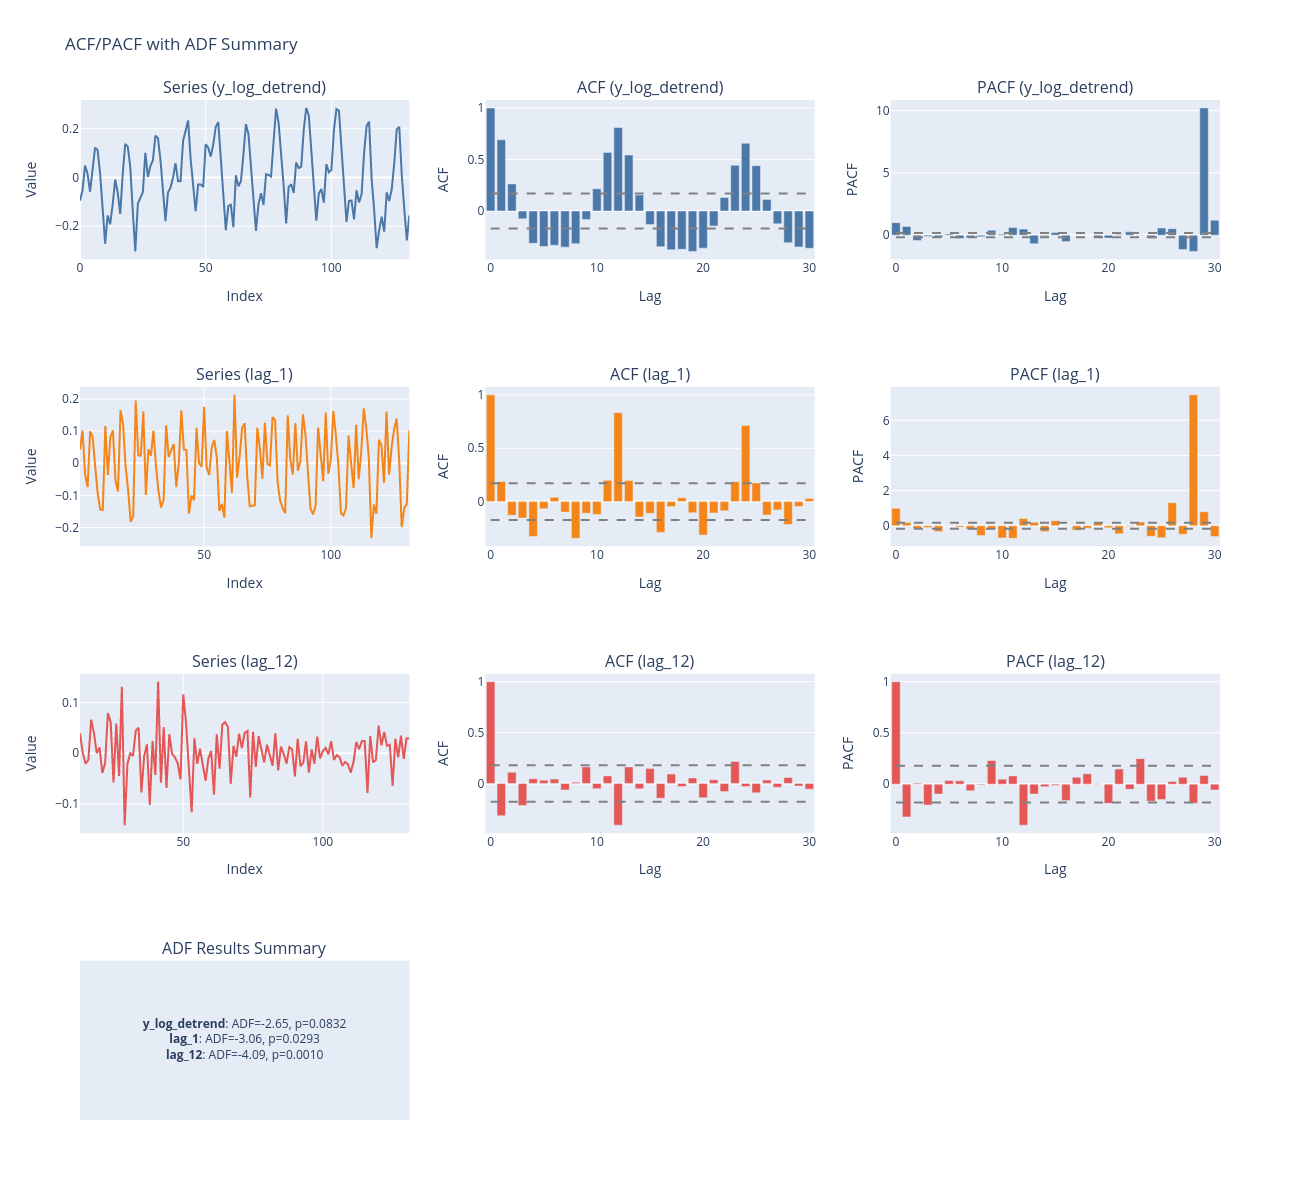

In [48]:
stationarity_check(train[["y_log_detrend", "lag_1", "lag_12"]], nlags=30, fig_type="png")

In [49]:
train.drop(columns=["lag_1", "lag_12"], inplace=True)

In [50]:
models = [LGBMRegressor(**config, verbosity=-1)]
mf = MLForecast(
    models=models,
    freq='MS',
    lags=[2], #removi lag 1 e lag 12
    lag_transforms={
        1: [
        RollingMean(window_size=12), # Nível de longo prazo (12 meses)]},
        SeasonalRollingMean(window_size=2, season_length=12)
        ],
        6: [ExpandingMean()], # Média acumulada (longo prazo)
    },
    target_transforms=[Differences([1, 12])],
)
mf.fit(train[["unique_id", "ds", "y_log_detrend"]], static_features=[], target_col="y_log_detrend")
result = mf.predict(h=12)

Recomposição: log(Y) = log(S+R) + log(T)

In [51]:
forecasting_trend = detrend_linear.predict(h=12)
result = pd.merge(result,forecasting_trend, on=["unique_id", "ds"], how="inner")
result["Reconstructed"] = result["LGBMRegressor"] + result["trend"]

Inversão: Y = exp(log(Y)) -> (Y = (S * R) * T)

In [52]:
result["y_pred"] = np.exp(result["Reconstructed"])
result["y"] = test["y"]

In [53]:
evaluate(result, 
         metrics=metrics, 
         models=["y_pred"], 
         id_col="unique_id", 
         time_col="ds", 
         target_col="y")

,unique_id,metric,y_pred
0,1,mae,42.734974
1,1,rmse,46.756106
2,1,bias,42.734974
3,1,cfe,470.084714
4,1,wape,0.088997
5,1,smape,0.042341


In [54]:
feature_importance = pd.DataFrame({
    'feature': mf.models_["LGBMRegressor"].feature_names_in_,
    'importance': mf.models_["LGBMRegressor"].feature_importances_
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

In [55]:
test["residual_LGBM_Detrend"] = result["y"] - result["y_pred"]

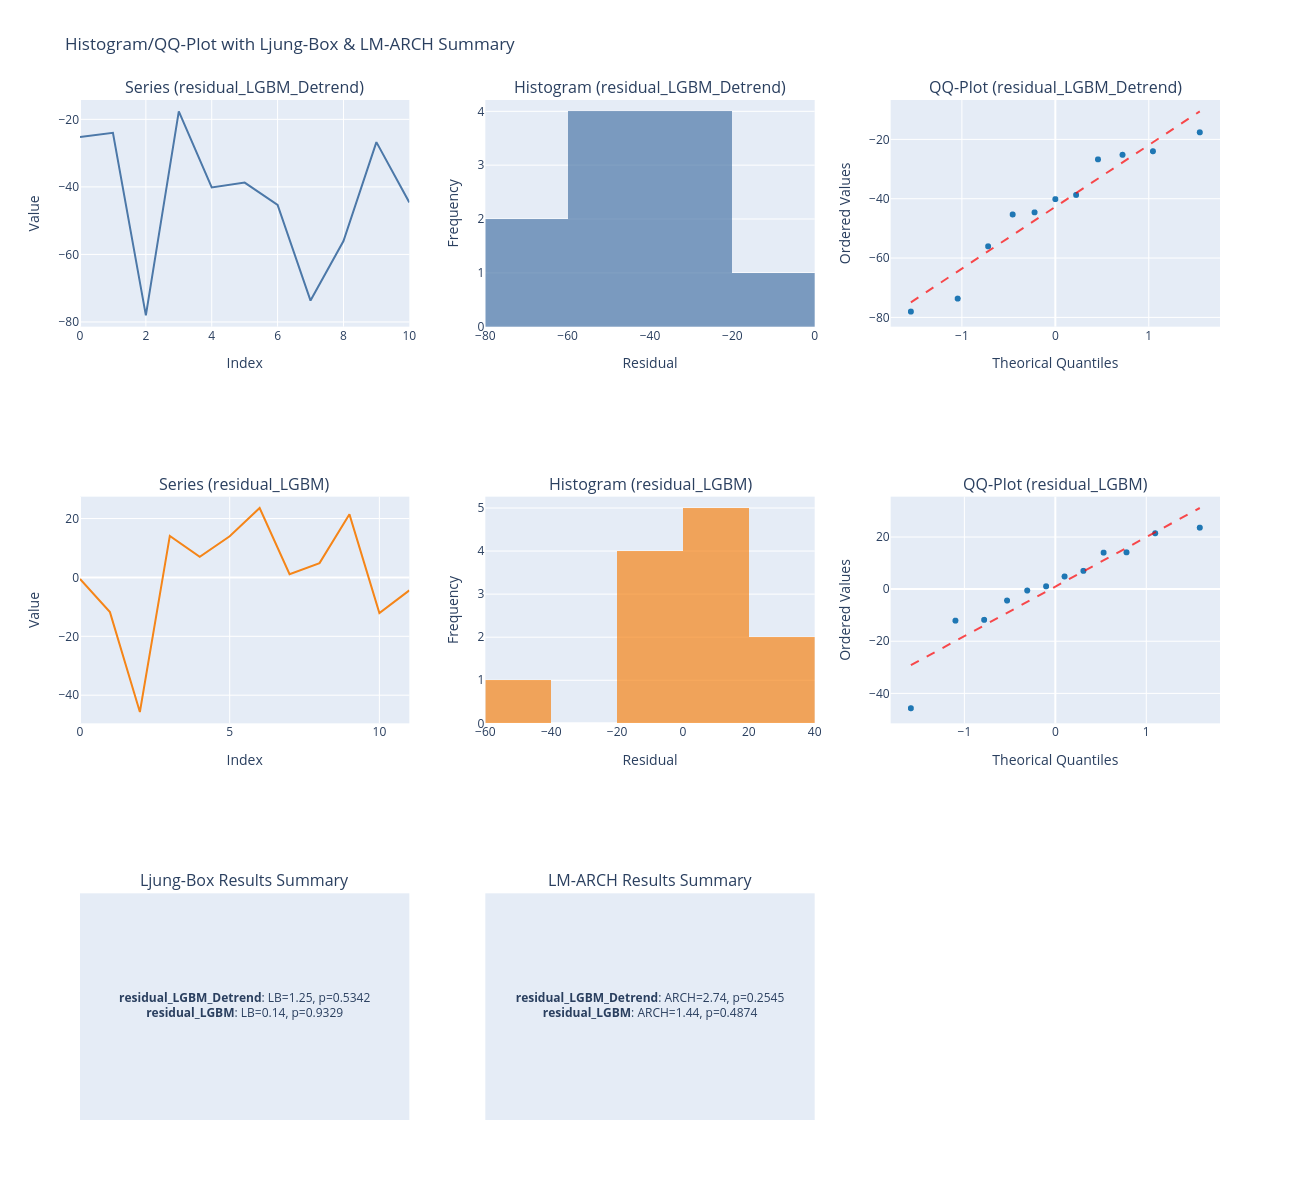

In [56]:
residual_check(test[["residual_LGBM_Detrend", "residual_LGBM"]], nlags=30, fig_type="png")

## MSTL + ML

1. Log de Y
2. Decompor via MSTL o período de 12
3. Treinar SeasonalNaive pela sazonalidade de 12
4. Treinar AutoETS pela tendencia
5. Treinar LGBM pelo Residuo
6. Adicionar todos e exponenciar
7. Avaliar resultados

In [57]:
from statsmodels.tsa.seasonal import MSTL
from statsforecast.models import SeasonalNaive, AutoARIMA

In [58]:
def convert_to_dataframe(result: MSTL) -> pd.Series:
        """
        Reconstructs the original time series from its MSTL decomposition components.

        Parameters
        ----------
        result : MSTL
            Fitted MSTL object containing the decomposition components.

        Returns
        -------
        pandas.Series
            Reconstructed time series obtained by summing the trend, seasonal, and residual components.
        """
        df = pd.DataFrame()
        df["data"] = result.observed
        df["trend"] = result.trend
        if isinstance(result.seasonal, pd.Series):
            df["seasonal"] = result.seasonal
        else:
            for seasonal_col in result.seasonal.columns:
                df[seasonal_col] = result.seasonal[seasonal_col]
        df["resid"] = result.resid

        return df

In [59]:
mstl = MSTL(train["y"], periods=12).fit()
decomp = convert_to_dataframe(mstl)

In [60]:
season_length = 12
seasonal = SeasonalNaive(season_length=season_length)
#trend = AutoARIMA(season_length=season_length, d=1, max_p =1, max_q=2)
trend = AutoETS(season_length=season_length, model="MMN") # Sazonalidade já foi removida, logo 'S' é N!
seasonal.fit(decomp["seasonal"])
trend.fit(decomp["trend"])

AutoETS

In [61]:
#trend.model_.get("arma")
#sarima = {"order": (1, 2, 2), "seasonal_order": (0, 1, 0)}

In [62]:
trend.model_.get("method")

'ETS(M,Md,N)'

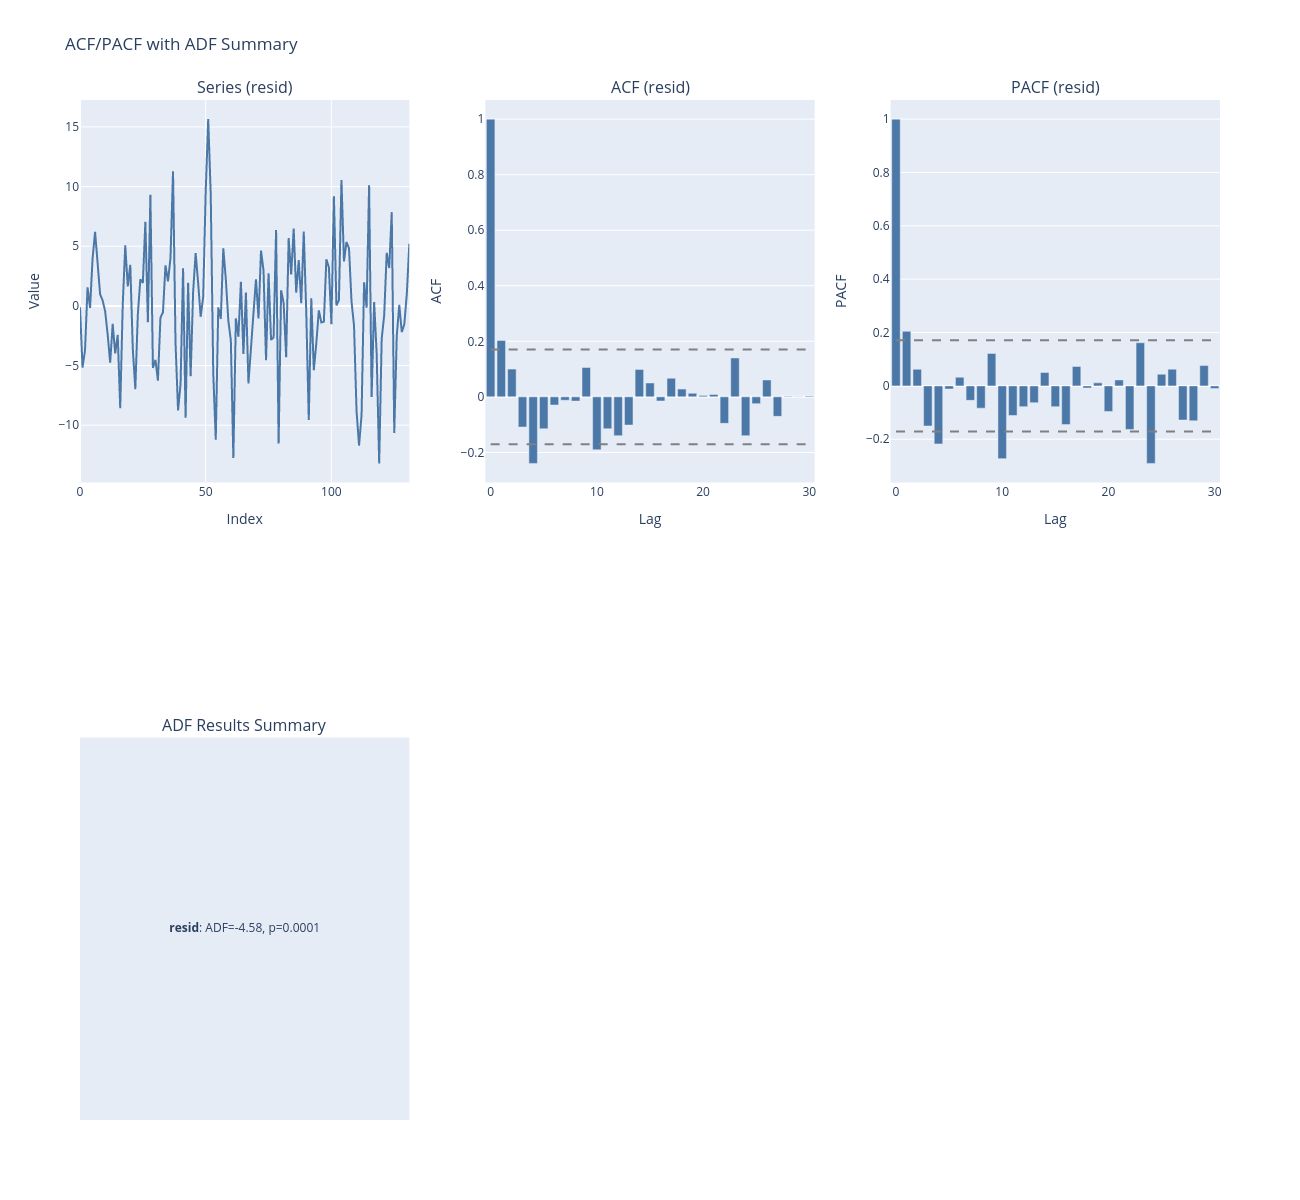

In [63]:
stationarity_check(decomp["resid"], nlags=30, fig_type="png")

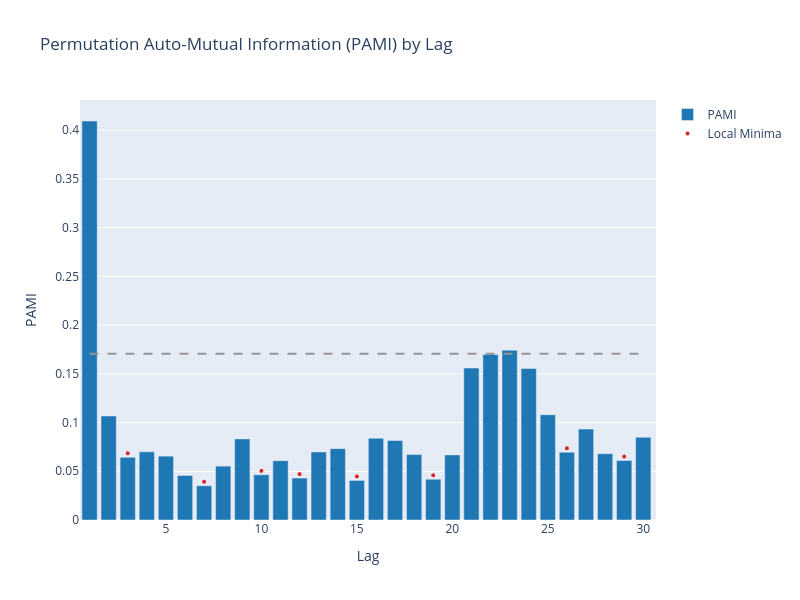

In [64]:
pami(decomp["resid"], nlags=30, fig_type="png", m=3, normalize=True)

In [65]:
decomp["ds"] = train["ds"]
decomp["unique_id"] = train["unique_id"]

In [66]:
mf = MLForecast(
    models=models,
    freq='MS',
    lags=[1, 3],
)
mf.fit(decomp[["resid", "ds", "unique_id"]], static_features=[], target_col="resid")

MLForecast(models=[LGBMRegressor], freq=MS, lag_features=['lag1', 'lag3'], date_features=[], num_threads=1)

In [67]:
result = mf.predict(h=12)
result["seasonal_forecast"] = seasonal.predict(h=12).get("mean")
result["trend_forecast"] = trend.predict(h=12).get("mean")
result["Reconstructed"] = result["LGBMRegressor"] + result["seasonal_forecast"] + result["trend_forecast"]
result["y_pred"] = result["Reconstructed"]
result["y"] = test["y"]

In [68]:
evaluate(result, 
         metrics=metrics, 
         models=["y_pred"], 
         id_col="unique_id", 
         time_col="ds", 
         target_col="y")

,unique_id,metric,y_pred
0,1,mae,11.333683
1,1,rmse,14.521539
2,1,bias,3.813138
3,1,cfe,45.757661
4,1,wape,0.023802
5,1,smape,0.012237


In [69]:
result["residual_reconstructed"] = result["y"] - result["y_pred"]

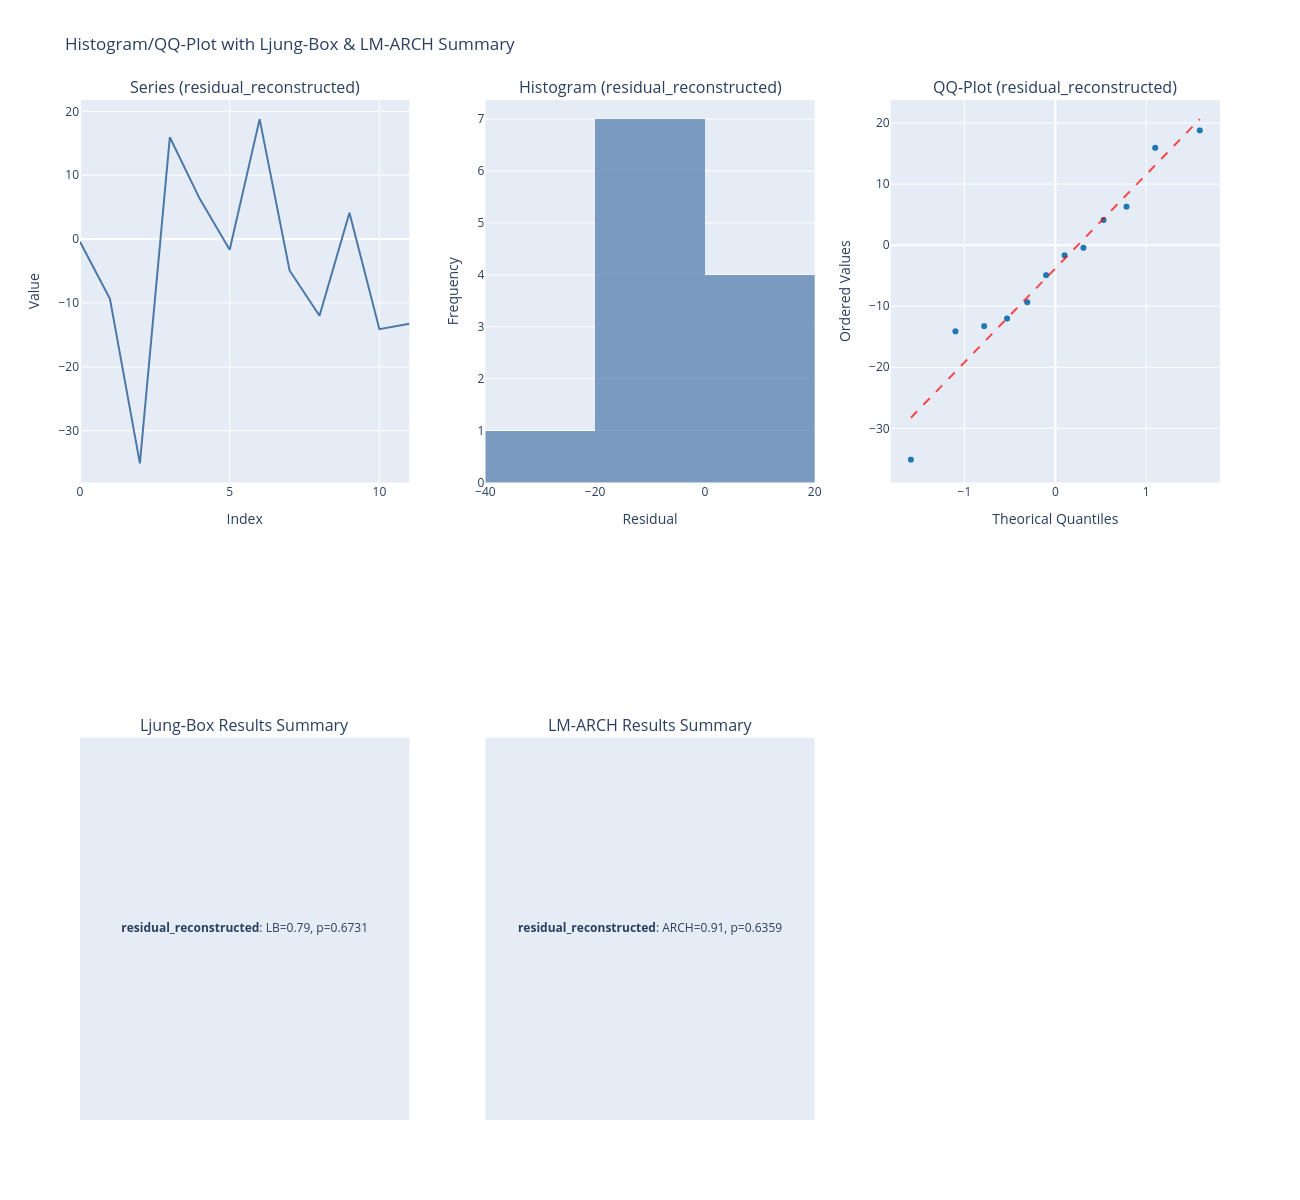

In [70]:
residual_check(result["residual_reconstructed"], nlags=30, fig_type="png")

In [71]:
import numpy as np
from typing import Union

def vertical_mean_absolute_change(
    past_forecast: Union[np.ndarray, list], 
    current_forecast: Union[np.ndarray, list], 
    normalize: bool = False,
) -> float:
    """
    Calculates the Mean Absolute Change Vertical (MAC_V).
    
    This function quantifies the average magnitude of change between an old forecast 
    (past_forecast) and a revised forecast (current_forecast) for the same future periods.
    A low value indicates high forecast stability (low nervousness).

    Args:
        past_forecast (np.ndarray or list): Forecasts from the PREVIOUS origin.
        current_forecast (np.ndarray or list): Forecasts from the CURRENT origin.
        normalize (bool): If True, the MAC_V is divided by the mean of the 
                          'current_forecast' to express the deviation as a percentage 
                          of the new plan's scale.

    Returns:
        float: The calculated MAC_V (absolute deviation) or the percentage deviation (if normalize=True).
    
    Raises:
        ValueError: If arrays are not 1-dimensional, do not have the same shape, 
                    or if the current forecast mean is zero during normalization.
    """
    
    past_forecast = np.asarray(past_forecast)
    current_forecast = np.asarray(current_forecast)

    if past_forecast.ndim != 1 or current_forecast.ndim != 1:
        raise ValueError("Input arrays must be 1-dimensional (vectors).")
    
    if past_forecast.shape != current_forecast.shape:
        raise ValueError("Input arrays must have the same shape (length) for comparison.")

    absolute_change = np.abs(current_forecast - past_forecast)
    mac_v = np.mean(absolute_change)
    
    normalization_factor = np.mean(current_forecast)
        
    return mac_v if normalize is False else mac_v / normalization_factor

def horizontal_mean_absolute_change(
    forecast: Union[np.ndarray, list], 
    normalize: bool = False,
) -> float:
    """
    Calculates the Mean Absolute Change Horizontal (MAC_H).
    
    MAC_H quantifies the average magnitude of change between adjacent time steps 
    within a single forecast window (measures the 'smoothness' of the forecast curve). 
    A lower value indicates higher horizontal stability.

    Args:
        forecast (np.ndarray or list): The single forecast window (e.g., T+1 to T+H).
        normalize (bool): If True, the MAC_H is divided by the mean of the 
                          'forecast' values to express the smoothness as a percentage 
                          of the forecast's scale.

    Returns:
        float: The calculated MAC_H (absolute deviation) or the percentage deviation (if normalize=True).
    
    Raises:
        ValueError: If the array is not 1-dimensional or has fewer than two elements.
    """
    
    forecast = np.asarray(forecast)

    if forecast.ndim != 1:
        raise ValueError("Input array must be 1-dimensional (vector).")
    
    if forecast.size < 2:
        raise ValueError("Input array must contain at least two elements for MAC_H calculation.")

    absolute_change = np.abs(forecast[1:] - forecast[:-1])
    mac_h = np.mean(absolute_change)
        
    return mac_h if normalize is False else mac_h / np.mean(forecast)

In [72]:
result = mf.predict(h=24)
result["seasonal_forecast"] = seasonal.predict(h=24).get("mean")
result["trend_forecast"] = trend.predict(h=24).get("mean")
result["Reconstructed"] = result["LGBMRegressor"] + result["seasonal_forecast"] + result["trend_forecast"]
result["y_pred"] = result["Reconstructed"]
#result["y"] = test["y"]

In [74]:
vertical_mean_absolute_change(result["y_pred"][:12], result["y_pred"][12:], normalize=True)

np.float64(0.09244362640110695)

In [75]:
horizontal_mean_absolute_change(result["y_pred"], normalize=True)

np.float64(0.08398010392696326)

In [72]:
import numpy as np

def calculate_metrics(y_true, y_pred_t, y_pred_t_minus_1, y_history, H, m):
    """
    Calcula MASE, MACv e MACh para uma única iteração de origem (tempo t).
    
    Args:
        y_true (np.ndarray): Valores reais no horizonte [t+1, ..., t+H].
        y_pred_t (np.ndarray): Previsões na origem t [H1, ..., HH].
        y_pred_t_minus_1 (np.ndarray): Previsões na origem t-1 [H1, ..., HH].
        y_history (np.ndarray): Histórico de dados da série.
        H (int): Horizonte de previsão (12).
        m (int): Período sazonal.
        
    Returns:
        tuple: (MASE, MACv, MACh)
    """
    # ----------------------------------------------------
    # 1. Termo de Escalonamento In-Sample (Denominator)
    #    Baseado na variação dos dados históricos y_history.
    #    A janela do histórico deve ser y_history[m:] - y_history[:-m] (de m+1 a t).
    #    Para simplificação, usaremos o MASE/MASC(H) denominator.
    # ----------------------------------------------------
    
    # As métricas de escala MASC(V) e MASE usam denominadores muito semelhantes,
    # que escalam a magnitude dos erros/mudanças pela média da variação sazonal 
    # no histórico disponível.
    
    # O denominador tem o formato: (C_H / C_hist) * sum(|y_i - y_{i-m}|)
    
    # Prepara a soma da diferença in-sample
    sum_hist_diff = np.sum(np.abs(y_history[m:] - y_history[:-m]))
    
    # MASE scaling factor (H / (t - m))
    t_length = len(y_history)
    mase_scaling_factor = H / (t_length - m)
    mase_denominator = mase_scaling_factor * sum_hist_diff

    # MASC(H) scaling factor ((H - 1) / (t - m))
    # Para o MASC(H), o somatório é de H-1 termos e a escala é ligeiramente diferente (t-m)
    masc_h_scaling_factor = (H - 1) / (t_length - m)
    masc_h_denominator = masc_h_scaling_factor * sum_hist_diff
    
    # MASC(V) scaling factor ((H - 1) / (t - m - 1))
    # Para o MASC(V), o somatório é de H-1 termos, e a escala é (t-m-1)
    # A diferença no denominador (t-m vs t-m-1) é uma pequena nuance nas métricas RMSSE/MASE
    # vs. RMSSC/MASCV no artigo. Vamos usar a definição do MASC(V) (Eq 10).
    masc_v_scaling_factor = (H - 1) / (t_length - m - 1)
    masc_v_denominator = masc_v_scaling_factor * sum_hist_diff
    
    # ----------------------------------------------------
    # 2. Numeradores
    # ----------------------------------------------------
    
    # Numerador MASE: Sum of absolute error in the forecast horizon H
    mase_numerator = np.sum(np.abs(y_true - y_pred_t))
    
    # Numerador MACv: Sum of absolute change between predictions (H-1 terms)
    # y_pred_t[1:] é a previsão de H2 a HH. y_pred_t_minus_1[:-1] é a de H1 a H(H-1).
    # Precisamos garantir que os índices correspondam aos mesmos pontos no tempo.
    # Para a origem t, as previsões são para t+1, t+2, ..., t+H
    # Para a origem t-1, as previsões são para t, t+1, ..., t+H-1
    # A sobreposição é de t+1 a t+H-1 (H-1 termos).
    
    # Para y_pred_t, a sobreposição é do índice 0 até H-2.
    # Para y_pred_t_minus_1, a sobreposição é do índice 1 até H-1.
    
    # Garante que os vetores tenham H-1 termos, eliminando a primeira previsão de t-1 
    # (que é para t) e a última previsão de t (que é para t+H).
    
    # O artigo 10 usa: H1 até H(H-1) da origem t vs H2 até HH da origem t-1.
    # Como as previsões são armazenadas como H1, H2... no array, 
    # os vetores são y_pred_t[:-1] (H1 a H11 de t) e y_pred_t_minus_1[1:] (H2 a H12 de t-1).
    
    # Simplificando a interpretação do array:
    # O array y_pred_t (H1..H12) deve ser comparado com y_pred_t_minus_1 (H1..H12).
    # Como elas se sobrepõem em H-1 termos, vamos usar a diferença absoluta entre H1..H11 de t
    # e H2..H12 de t-1.
    
    # O artigo sugere a sobreposição de: H1..H(H-1) da origem t, com H2..HH da origem t-1[cite: 272].
    # No array, isso é:
    pred_t_overlap = y_pred_t[:-1]  # H1 a H11
    pred_t_minus_1_overlap = y_pred_t_minus_1[1:] # H2 a H12
    
    mac_v_numerator = np.sum(np.abs(pred_t_overlap - pred_t_minus_1_overlap))
    
    # Numerador MACh: Sum of absolute change between adjacent predictions (H-1 terms)
    # A mudança é entre H2 e H1, H3 e H2, ..., HH e H(H-1).
    mac_h_numerator = np.sum(np.abs(y_pred_t[1:] - y_pred_t[:-1]))
    
    # ----------------------------------------------------
    # 3. Cálculo Final
    # ----------------------------------------------------
    
    # MASE
    mase = mase_numerator / mase_denominator
    
    # MACv
    mac_v = mac_v_numerator / masc_v_denominator
    
    # MACh
    mac_h = mac_h_numerator / masc_h_denominator

    # SMAPC (não escalado)
    smac_v_numerator_sum = np.sum(np.abs(pred_t_overlap - pred_t_minus_1_overlap) / (np.abs(pred_t_overlap) + np.abs(pred_t_minus_1_overlap)))
    smapc = (200 / (H - 1)) * smac_v_numerator_sum
    
    return mase, mac_v, mac_h, smapc

# NOTA: O cálculo para uma implementação real deve ser feito em um loop 
# sobre todas as origens (t) e, em seguida, calculada a média dos resultados, 
# conforme sugerido pelo artigo (mean MASE, mean MASC, etc.)[cite: 264, 294].